In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, LSTM, Dropout, BatchNormalization, Conv1D, Layer, Activation, Add, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Datasets/MHealth/Sensor_Fusion_WithNamesF.csv")

label = LabelEncoder()
data['Labels'] = label.fit_transform(data['Activity'])
data.head()


,acc_x,acc_y,acc_z,gry_x,gry_y,gry_z,mag_x,mag_y,mag_z,activityID,Activity,Labels
0,2.6493,-9.4517,0.37683,-0.20965,-0.88931,-0.50884,0.56366,0.54482,-0.73822,1,Standing,4
1,2.4157,-9.5306,0.40179,-0.20965,-0.88931,-0.50884,0.56810,0.91175,-0.88628,1,Standing,4
2,2.3865,-9.5991,0.48141,-0.20037,-0.86867,-0.50688,0.21110,0.54835,-1.01980,1,Standing,4
3,2.3758,-9.5997,0.42919,-0.20037,-0.86867,-0.50688,0.21565,1.28220,-1.17150,1,Standing,4
4,2.3239,-9.5406,0.40038,-0.20037,-0.86867,-0.50688,0.56810,0.91175,-0.88628,1,Standing,4


In [ ]:
label.classes_

array(['Jogging', 'Laying', 'Running', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

In [ ]:
X = data[['acc_x', "acc_y", 'acc_z', 'gry_x', 'gry_y', 'gry_z', 'mag_x',"mag_y",'mag_z']]
Y = data['Labels']

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
Scaled_X = pd.DataFrame(X, columns=['acc_x', "acc_y", 'acc_z', 'gry_x', 'gry_y', 'gry_z', 'mag_x',"mag_y",'mag_z'])
Scaled_X["Labels"] = Y.values
Scaled_X.head()

,acc_x,acc_y,acc_z,gry_x,gry_y,gry_z,mag_x,mag_y,mag_z,Labels
0,0.572046,-0.327101,-0.064038,-0.264550,-0.927019,-1.113149,0.012323,0.027794,-0.008337,4
1,0.537104,-0.338509,-0.059997,-0.264550,-0.927019,-1.113149,0.012386,0.035786,-0.010420,4
2,0.532736,-0.348413,-0.047104,-0.247086,-0.888517,-1.109875,0.007378,0.027871,-0.012299,4
3,0.531135,-0.348500,-0.055560,-0.247086,-0.888517,-1.109875,0.007441,0.043854,-0.014434,4
4,0.523372,-0.339955,-0.060225,-0.247086,-0.888517,-1.109875,0.012386,0.035786,-0.010420,4


In [ ]:
import scipy.stats as stats

In [ ]:
frame_size = 100
overlap_size =10

In [ ]:
from re import M
def get_frames(data, frame_size, overlap_size):
  frames = []
  labels = []
  n_features = 9
  for i in range(0, len(data) - frame_size, overlap_size):
    x = data["acc_x"].values[i: i + frame_size]
    y = data["acc_y"].values[i: i + frame_size]
    z = data["acc_z"].values[i: i + frame_size]
    x2 = data["gry_x"].values[i: i + frame_size]
    y2 = data["gry_y"].values[i: i + frame_size]
    z2= data["gry_z"].values[i: i + frame_size]
    m2 = data["mag_x"].values[i: i + frame_size]
    n2 = data["mag_y"].values[i: i + frame_size]
    o2 = data["mag_z"].values[i: i + frame_size]


    label = stats.mode(data["Labels"][i: i + frame_size])[0]
    frames.append([x, y, z, x2, y2, z2, m2, n2, o2])
    labels.append(label)
  frames = np.array(frames).reshape(-1, frame_size, n_features)
  labels = np.array(labels)
  return frames, labels


In [ ]:
X_data, Y_data = get_frames(Scaled_X, frame_size, overlap_size)

In [ ]:
X_data.shape, Y_data.shape

((85390, 100, 9), (85390,))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.75, random_state=42)

In [ ]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((68312, 100, 9), (68312,), (12809, 100, 9), (12809,))

In [ ]:
import tensorflow as tf
from keras.layers import Layer, Conv1D, BatchNormalization, Activation, LSTM, Multiply, Input, Dense, Bidirectional, Dropout
from keras.models import Model

class TemporalAttentionLayer(Layer):
    def __init__(self):
        super(TemporalAttentionLayer, self).__init__()
        self.conv = Conv1D(filters=1, kernel_size=5, strides=1, padding='same', use_bias=False)
        self.bn = BatchNormalization(epsilon=1e-5, momentum=0.01, trainable=True)
        self.activation = Activation("sigmoid")
        self.lstm = LSTM(n_features, return_sequences=True)

    def call(self, x):
        # Temporal Attention Computation
        x_compress = channelPoolingTemporal(x)

        # Define Conv1D dynamically inside call()
        x_out = self.conv(x_compress)
        x_out = self.bn(x_out)
        attention_weights = self.activation(x_out)

        output_tensor = Multiply()([x, attention_weights])

        # LSTM Computation
        lstm_out = self.lstm(x)

        # Residual Connection
        residual_output = tf.add(output_tensor, lstm_out)

        return residual_output

def channelPoolingTemporal(x):
    max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
    mean_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
    return tf.concat([max_pool, mean_pool], axis=-1)

# Define local model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))  # (sequence_length, n_features)
feature_1 = Conv1D(filters=9, kernel_size=3, strides=1, padding='same', use_bias=False)(inputs)
attention_output = TemporalAttentionLayer()(feature_1)

# # Add LSTM layers
x = Bidirectional(LSTM(256, return_sequences=True))(attention_output)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(64, return_sequences=False))(x)

# Add Dense layers
x = Dense(64, LeakyReLU(negative_slope= 0.1),kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(32, LeakyReLU(negative_slope= 0.1), kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dense(16, LeakyReLU(negative_slope= 0.1), kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dense(8, LeakyReLU(negative_slope= 0.1), kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

outputs = Dense(7, activation='softmax')(x)


local_model = Model(inputs=inputs, outputs=outputs)
local_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 9)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 100, 9)              │             243 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ temporal_attention_layer             │ (None, 100, 9)              │             698 │
│ (TemporalAttentionLayer)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 512)            │         544,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 100, 256)            │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │              63 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,377,508 (5.25 MB)

 Trainable params: 1,377,506 (5.25 MB)

 Non-trainable params: 2 (8.00 B)

In [ ]:
# Compile the model
local_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Fit the model
history = local_model.fit(X_train, Y_train, epochs=40, batch_size=128, validation_data=(X_val, Y_val), verbose=1)


Epoch 1/40
534/534 ━━━━━━━━━━━━━━━━━━━━ 46s 69ms/step - accuracy: 0.6277 - loss: 1.6777 - val_accuracy: 0.9770 - val_loss: 0.3808
Epoch 2/40
534/534 ━━━━━━━━━━━━━━━━━━━━ 37s 69ms/step - accuracy: 0.9722 - loss: 0.3710 - val_accuracy: 0.9721 - val_loss: 0.3093
Epoch 3/40
534/534 ━━━━━━━━━━━━━━━━━━━━ 38s 70ms/step - accuracy: 0.9726 - loss: 0.3106 - val_accuracy: 0.9862 - val_loss: 0.2363
Epoch 4/40
534/534 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - accuracy: 0.9839 - loss: 0.2408 - val_accuracy: 0.9883 - val_loss: 0.2015
Epoch 5/40
534/534 ━━━━━━━━━━━━━━━━━━━━ 38s 70ms/step - accuracy: 0.9863 - loss: 0.2113 - val_accuracy: 0.9918 - val_loss: 0.1766
Epoch 6/40
534/534 ━━━━━━━━━━━━━━━━━━━━ 38s 70ms/step - accuracy: 0.9866 - loss: 0.1906 - val_accuracy: 0.9372 - val_loss: 0.3114
Epoch 7/40
534/534 ━━━━━━━━━━━━━━━━━━━━ 38s 70ms/step - accuracy: 0.9845 - loss: 0.1859 - val_accuracy: 0.9927 - val_loss: 0.1539
Epoch 8/40
534/534 ━━━━━━━━━━━━━━━━━━━━ 38s 70ms/step - accuracy: 0.9908 - loss: 0.1581 - 

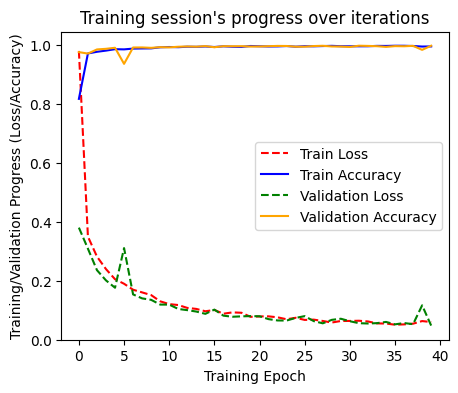

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(np.array(history.history['loss']), "r--", label = "Train Loss")
plt.plot(np.array(history.history['accuracy']), "b-", label = "Train Accuracy")
plt.plot(np.array(history.history['val_loss']), "g--", label = "Validation Loss")
plt.plot(np.array(history.history['val_accuracy']), "orange", label = "Validation Accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='center right')
plt.ylabel('Training/Validation Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

In [ ]:
# Evaluate the model
loss, local_accuracy = local_model.evaluate(X_test, Y_test)
print(f'Loss: {loss}, Accuracy: {local_accuracy}')

401/401 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9968 - loss: 0.0553
Loss: 0.05331753194332123, Accuracy: 0.9973456263542175


401/401 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step


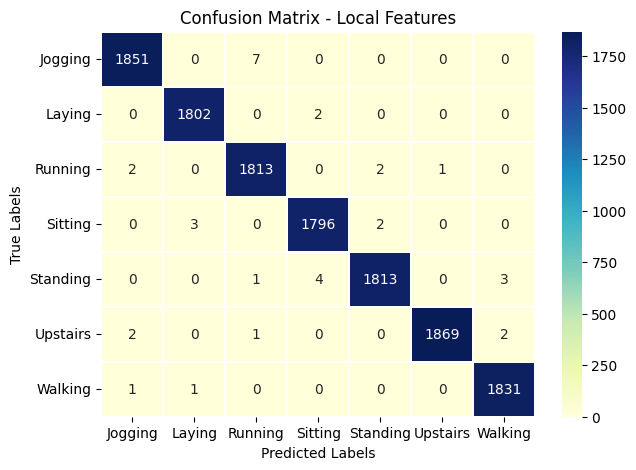

In [ ]:
# Ensure Y_test is a 1D array
max_test = Y_test if Y_test.ndim == 1 else np.argmax(Y_test, axis=1)

# Get model predictions
max_predictions = np.argmax(local_model.predict(X_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(max_test, max_predictions)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', linewidths = 0.1, xticklabels=label.classes_, yticklabels=label.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Local Features')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv1D, BatchNormalization, Activation, LSTM, Multiply, Input
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

class TemporalAttentionLayer(Layer):
    def __init__(self):
        super(TemporalAttentionLayer, self).__init__()
        self.conv1d = Conv1D(filters=9, kernel_size=5, strides=1, padding='same', use_bias=False)
        self.bn = BatchNormalization(epsilon=1e-5, momentum=0.01, trainable=True)
        self.activation = Activation("sigmoid")
        self.lstm = LSTM(9, return_sequences=True)

    def call(self, x):
        # Extract energy features per axis
        energy_features = compute_energy_features_per_axis(x)

        attention_input = self.conv1d(energy_features)
        attention_input = self.bn(attention_input)
        attention_weights = self.activation(attention_input)

        # Apply attention weights to original input
        output_tensor = Multiply()([x, attention_weights])

        # LSTM Computation
        lstm_out = self.lstm(x)

        # Residual Connection
        residual_output = tf.add(output_tensor, lstm_out)

        return residual_output

In [ ]:
# Define local model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))  # (sequence_length, n_features)
attention_output = TemporalAttentionLayer()(inputs)

# # Add LSTM layers
x = Bidirectional(LSTM(256, return_sequences=True))(attention_output)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(64, return_sequences=False))(x)

# Add Dense layers
x = Dense(64, LeakyReLU(negative_slope= 0.1),kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(32, LeakyReLU(negative_slope= 0.1), kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dense(16, LeakyReLU(negative_slope= 0.1), kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dense(8, LeakyReLU(negative_slope= 0.1), kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

outputs = Dense(7, activation='softmax')(x)

global_model = Model(inputs=inputs, outputs=outputs)
global_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100, 9)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ temporal_attention_layer_1           │ (None, 100, 9)              │           1,530 │
│ (TemporalAttentionLayer)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 100, 512)            │         544,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 100, 256)            │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 7)                   │              63 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,378,097 (5.26 MB)

 Trainable params: 1,378,079 (5.26 MB)

 Non-trainable params: 18 (72.00 B)

In [ ]:
# Compile the model
global_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  

# Fit the model
history = global_model.fit(X_train, Y_train, epochs=40, batch_size=128, validation_data=(X_val, Y_val), verbose=1)

Epoch 1/40
534/534 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - accuracy: 0.5732 - loss: 1.8035 - val_accuracy: 0.9412 - val_loss: 0.4279
Epoch 2/40
534/534 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - accuracy: 0.9621 - loss: 0.3718 - val_accuracy: 0.9857 - val_loss: 0.2525
Epoch 3/40
534/534 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - accuracy: 0.9785 - loss: 0.2712 - val_accuracy: 0.9721 - val_loss: 0.2649
Epoch 4/40
534/534 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - accuracy: 0.9810 - loss: 0.2356 - val_accuracy: 0.9728 - val_loss: 0.2583
Epoch 5/40
534/534 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - accuracy: 0.9767 - loss: 0.2369 - val_accuracy: 0.9911 - val_loss: 0.1742
Epoch 6/40
534/534 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - accuracy: 0.9885 - loss: 0.1793 - val_accuracy: 0.9913 - val_loss: 0.1613
Epoch 7/40
534/534 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - accuracy: 0.9881 - loss: 0.1714 - val_accuracy: 0.9899 - val_loss: 0.1508
Epoch 8/40
534/534 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - accuracy: 0.9906 - loss: 0.1512 - 

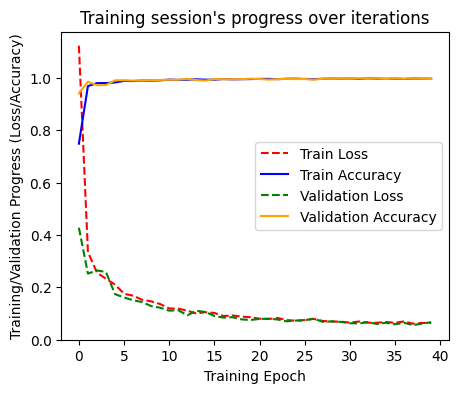

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(np.array(history.history['loss']), "r--", label = "Train Loss")
plt.plot(np.array(history.history['accuracy']), "b-", label = "Train Accuracy")
plt.plot(np.array(history.history['val_loss']), "g--", label = "Validation Loss")
plt.plot(np.array(history.history['val_accuracy']), "orange", label = "Validation Accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='center right')
plt.ylabel('Training/Validation Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

In [ ]:
# Evaluate the model
loss, global_accuracy = global_model.evaluate(X_test, Y_test)
print(f'Loss: {loss}, Accuracy: {global_accuracy}')

401/401 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9956 - loss: 0.0716
Loss: 0.06946281343698502, Accuracy: 0.9960964918136597


401/401 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step


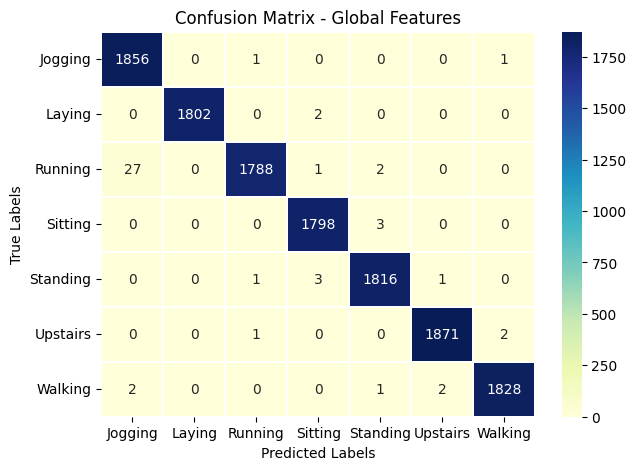

In [ ]:
# Ensure Y_test is a 1D array
max_test = Y_test if Y_test.ndim == 1 else np.argmax(Y_test, axis=1)

# Get model predictions
max_predictions = np.argmax(global_model.predict(X_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(max_test, max_predictions)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', linewidths = 0.1, xticklabels=label.classes_, yticklabels=label.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Global Features')
plt.show()

401/401 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
401/401 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
Using Weights: Energy Model = 0.50, Local Model = 0.50
Weighted Fusion Accuracy: 0.9985


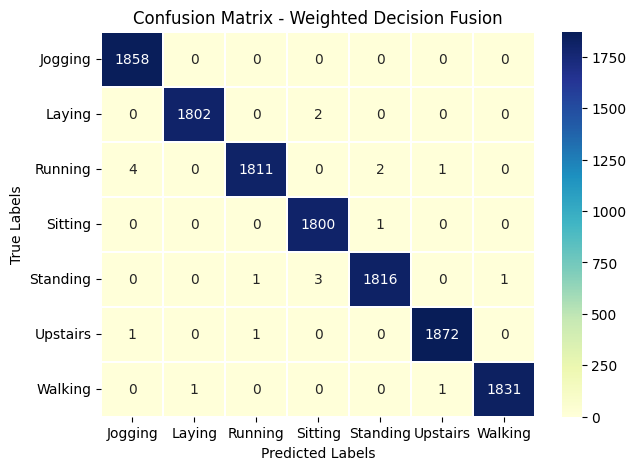

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

def weighted_fusion(energy_model, local_model, X_test, val_acc_global, val_acc_local):

    # Get softmax probabilities from both models
    prob_energy = energy_model.predict(X_test)
    prob_local = local_model.predict(X_test)

    # Compute dynamic weights (normalize validation accuracies)
    total_acc = val_acc_global + val_acc_local
    weight_global = val_acc_global / total_acc
    weight_local = val_acc_local / total_acc

    print(f"Using Weights: Energy Model = {weight_global:.2f}, Local Model = {weight_local:.2f}")

    # Compute weighted probabilities
    weighted_probs = (weight_global * prob_energy) + (weight_local * prob_local)

    # Get final predictions (argmax over weighted sum)
    final_predictions = np.argmax(weighted_probs, axis=1)

    return final_predictions


# Compute final weighted fusion predictions
combined_predictions = weighted_fusion(global_model, local_model, X_test, global_accuracy, local_accuracy)

# Compute accuracy
fusion_accuracy = accuracy_score(Y_test, combined_predictions)
print(f'Weighted Fusion Accuracy: {fusion_accuracy:.4f}')

# Compute confusion matrix
cm = confusion_matrix(Y_test, combined_predictions)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.1, xticklabels=label.classes_, yticklabels=label.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Weighted Decision Fusion')
plt.show()
